In [2]:
!pip3 install timm
!pip install scikit-learn
!pip3 install matplotlib
import timm
import torch


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


/Users/funlau/Documents/potato/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Loading Data

In [3]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((384, 384)),  # match model input
    transforms.ToTensor(),          # convert to tensor
])

dataset = datasets.ImageFolder('potato_dataset', transform=transform)
print(dataset.class_to_idx) 

{'not_potato': 0, 'potato': 1}


In [4]:
# Split into train/test
from torch.utils.data import random_split

# Define sizes
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size  # to ensure total size is preserved

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Print sizes
print(f"Train size: {len(train_dataset)}, Validation size: {len(val_dataset)}, Test size: {len(test_dataset)}")

Train size: 138, Validation size: 17, Test size: 18


In [5]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

### Model Creation and Training

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class NextViTPotatoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model('nextvit_small.bd_ssld_6m_in1k_384', pretrained=True)
        self.backbone.head = nn.Linear(self.backbone.head.in_features, 1)

    def forward(self, x):
        features = self.backbone.forward_features(x)
        features = features.mean(dim=[2, 3])
        return self.backbone.head(features)
    
    def predict(self, x, threshold=0.5):
        self.eval()
        with torch.no_grad():
            logits = self(x)
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).int()
        return preds, probs

In [7]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NextViTPotatoClassifier().to(device)

for param in model.parameters():
    param.requires_grad = False  # freeze everything

# Unfreeze only the classifier head
for param in model.backbone.head.parameters():
    param.requires_grad = True


# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.backbone.head.parameters(), lr=1e-3)

In [8]:
#show trainable parameters
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


backbone.head.weight
backbone.head.bias
Total parameters: 30,739,393
Trainable parameters: 1,025


In [9]:
def reset_head_weights(model):
    for layer in model.backbone.head.modules():
        if isinstance(layer, nn.Linear):
            layer.reset_parameters()

In [ ]:
# Training loop
reset_head_weights(model)  # Reset weights before training

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct, total = 0, 0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)  # shape: [B, 1]

        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss
        total_loss += loss.item()

         # Track accuracy
        probs = torch.sigmoid(outputs)
        preds = (probs > 0.5).int()
        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)
    
    epoch_acc = correct / total
    torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}, 'checkpoint.pth')


    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.4f}")

Epoch 1, Loss: 10.6873, Accuracy: 0.7174
Epoch 2, Loss: 6.7878, Accuracy: 0.9275
Epoch 3, Loss: 4.7011, Accuracy: 0.9493
Epoch 4, Loss: 3.8918, Accuracy: 0.9638
Epoch 5, Loss: 2.4384, Accuracy: 0.9928
Epoch 6, Loss: 3.3877, Accuracy: 0.9348
Epoch 7, Loss: 3.0024, Accuracy: 0.9638
Epoch 8, Loss: 1.7831, Accuracy: 0.9783
Epoch 9, Loss: 1.7182, Accuracy: 0.9710
Epoch 10, Loss: 2.1720, Accuracy: 0.9783


### Model Evaluation and Testing

In [11]:
def evaluate(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.cpu()
            labels = labels.cpu().float().unsqueeze(1)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).int()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total


In [13]:
val_acc = evaluate(model, val_loader)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.9412


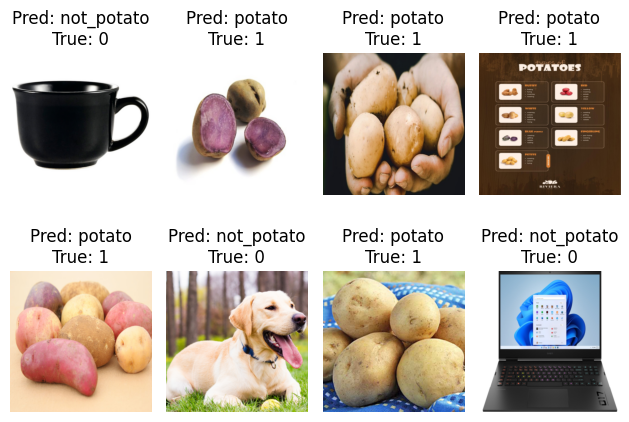

Test Accuracy: 1.0000


In [14]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

model.eval()
correct, total = 0, 0
class_names = dataset.classes  # ['not_potato', 'potato']

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)

        outputs = model(imgs)        # raw logits
        probs = torch.sigmoid(outputs)           # convert to probabilities
        preds = (probs > 0.5).int()              # threshold

        correct += (preds == labels.int()).sum().item()
        total += labels.size(0)

        preds = preds.cpu().numpy()
        labels = labels.cpu().numpy()

        # Plot first 8 images
        for i in range(min(8, len(imgs))):
            plt.subplot(2, 4, i + 1)
            plt.imshow(imgs[i].permute(1, 2, 0))  # [C, H, W] -> [H, W, C]
            plt.title(f"Pred: {class_names[preds[i][0]]}\nTrue: {int(labels[i][0])}")
            plt.axis('off')
        plt.tight_layout()
        plt.show()
        break  # Only show one batch

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")


### Save Model

In [15]:
torch.save(model, 'nextvit_binary.pth')

In [16]:
!pip install onnx


[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [17]:
# Export to ONNX
dummy_input = torch.randn(1, 3, 384, 384).to(device)

torch.onnx.export(
    model, 
    dummy_input,
    "nextvit_potatoclassifer.onnx",           # output file name
    input_names=["input"], 
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=16,
    verbose=False,
)

### Quantization

In [22]:
for name, param in model.named_parameters():
    print(name, param.dtype)


backbone.stem.0.conv.weight torch.float32
backbone.stem.0.norm.weight torch.float32
backbone.stem.0.norm.bias torch.float32
backbone.stem.1.conv.weight torch.float32
backbone.stem.1.norm.weight torch.float32
backbone.stem.1.norm.bias torch.float32
backbone.stem.2.conv.weight torch.float32
backbone.stem.2.norm.weight torch.float32
backbone.stem.2.norm.bias torch.float32
backbone.stem.3.conv.weight torch.float32
backbone.stem.3.norm.weight torch.float32
backbone.stem.3.norm.bias torch.float32
backbone.stages.0.blocks.0.patch_embed.conv.weight torch.float32
backbone.stages.0.blocks.0.patch_embed.norm.weight torch.float32
backbone.stages.0.blocks.0.patch_embed.norm.bias torch.float32
backbone.stages.0.blocks.0.mhca.group_conv3x3.weight torch.float32
backbone.stages.0.blocks.0.mhca.norm.weight torch.float32
backbone.stages.0.blocks.0.mhca.norm.bias torch.float32
backbone.stages.0.blocks.0.mhca.projection.weight torch.float32
backbone.stages.0.blocks.0.norm.weight torch.float32
backbone.stag

In [27]:
from torch.quantization import quantize_dynamic

torch.backends.quantized.engine = 'qnnpack'
quantized_model = quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)
print(quantized_model)


NextViTPotatoClassifier(
  (backbone): NextViT(
    (stem): Sequential(
      (0): ConvNormAct(
        (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (1): ConvNormAct(
        (conv): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (2): ConvNormAct(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (3): ConvNormAct(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (norm): BatchNorm2d(64, eps=1e-05, 

In [34]:
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)

with torch.no_grad():
    for imgs, _ in test_loader:  # e.g., val_loader
        imgs = imgs.to('cpu')  # Must run on CPU
        model(imgs)

quantized_model = torch.quantization.convert(model, inplace=False)
print(quantized_model)

/Users/funlau/Documents/potato/.venv/lib/python3.13/site-packages/torch/ao/quantization/observer.py:244: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


NextViTPotatoClassifier(
  (backbone): NextViT(
    (stem): Sequential(
      (0): ConvNormAct(
        (conv): QuantizedConv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), scale=0.016343697905540466, zero_point=64, padding=(1, 1))
        (norm): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (1): ConvNormAct(
        (conv): QuantizedConv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), scale=0.12712720036506653, zero_point=84, padding=(1, 1))
        (norm): QuantizedBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (2): ConvNormAct(
        (conv): QuantizedConv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.1533602923154831, zero_point=79, padding=(1, 1))
        (norm): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU(inplace=True)
      )
      (3): ConvNo

In [36]:
for name, param in quantized_model.named_parameters():
    print(name, param.dtype)

backbone.stem.0.norm.weight torch.float32
backbone.stem.0.norm.bias torch.float32
backbone.stem.1.norm.weight torch.float32
backbone.stem.1.norm.bias torch.float32
backbone.stem.2.norm.weight torch.float32
backbone.stem.2.norm.bias torch.float32
backbone.stem.3.norm.weight torch.float32
backbone.stem.3.norm.bias torch.float32
backbone.stages.0.blocks.0.patch_embed.norm.weight torch.float32
backbone.stages.0.blocks.0.patch_embed.norm.bias torch.float32
backbone.stages.0.blocks.0.mhca.norm.weight torch.float32
backbone.stages.0.blocks.0.mhca.norm.bias torch.float32
backbone.stages.0.blocks.0.norm.weight torch.float32
backbone.stages.0.blocks.0.norm.bias torch.float32
backbone.stages.0.blocks.1.mhca.norm.weight torch.float32
backbone.stages.0.blocks.1.mhca.norm.bias torch.float32
backbone.stages.0.blocks.1.norm.weight torch.float32
backbone.stages.0.blocks.1.norm.bias torch.float32
backbone.stages.0.blocks.2.mhca.norm.weight torch.float32
backbone.stages.0.blocks.2.mhca.norm.bias torch.fl

In [37]:
import os
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 124.872101
Size (MB): 32.309665


In [44]:
import time
def time_model_evaluation(model, test_data):
    model.to('cpu')
    s = time.time()
    accuracy = evaluate(model, test_data)
    elapsed = time.time() - s
    print(f'Accuracy: {accuracy:.3f}\nElapsed time (seconds): {elapsed:.1f}')

time_model_evaluation(model, test_loader)
time_model_evaluation(quantized_model, test_loader)

Accuracy: 1.000
Elapsed time (seconds): 3.8


NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [MPS, Meta, QuantizedCPU, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMTIA, AutogradMeta, Tracer, AutocastCPU, AutocastMTIA, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

MPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:78 [backend fallback]
Meta: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/quantized/cpu/qconv.cpp:2044 [kernel]
BackendSelect: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:479 [backend fallback]
Functionalize: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:349 [backend fallback]
Named: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:100 [backend fallback]
AutogradOther: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:63 [backend fallback]
AutogradCPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:67 [backend fallback]
AutogradCUDA: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:75 [backend fallback]
AutogradXLA: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:83 [backend fallback]
AutogradMPS: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:91 [backend fallback]
AutogradXPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:71 [backend fallback]
AutogradHPU: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:104 [backend fallback]
AutogradLazy: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:87 [backend fallback]
AutogradMTIA: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:79 [backend fallback]
AutogradMeta: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:95 [backend fallback]
Tracer: registered at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/TraceTypeManual.cpp:294 [backend fallback]
AutocastCPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastMTIA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:466 [backend fallback]
AutocastXPU: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:504 [backend fallback]
AutocastMPS: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:208 [backend fallback]
PythonTLSSnapshot: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:475 [backend fallback]
PreDispatch: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]
